In [1]:
# check GPU status
!nvidia-smi

Thu Apr 18 11:00:24 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-16GB           On  |   00000000:18:00.0 Off |                    0 |
| N/A   41C    P0             43W /  300W |       0MiB /  16384MiB |      0%   E. Process |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [18]:
!pip install -q librosa
!pip install -q opendatasets

In [73]:
!pip install -q torchsummary

In [2]:
"""This is an Ellen issue. For some reason I keep on getting path issue on the modules."""
import sys
print(sys.path)

PATH = "/projectnb/ec500kb/students/eburhan/Project/venvs/mynewenv/lib/python3.10/site-packages"
sys.path.append(PATH)

['/projectnb/dl523/students/eburhan/EC523-SER', '', '/share/pkg.7/pytorch/1.12.1/install/lib/SCC/../python3.10/site-packages', '/share/pkg.8/python3/3.10.12/install/lib/python310.zip', '/share/pkg.8/python3/3.10.12/install/lib/python3.10', '/share/pkg.8/python3/3.10.12/install/lib/python3.10/lib-dynload', '/usr4/ec500kb/eburhan/.local/lib/python3.10/site-packages', '/share/pkg.8/python3/3.10.12/install/lib/python3.10/site-packages']


In [3]:
# Import libraries
import math
import random
import IPython
import os
import torch
import torchvision
import librosa
import torchaudio
# import torchvision.transforms as transforms
from torchaudio.transforms import MelSpectrogram
from torchaudio import transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import pandas as pd

from torch.utils.data import Dataset, DataLoader, random_split
from torchaudio.utils import download_asset
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from torchvision import datasets
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from torchsummary import summary

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

In [4]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [5]:
from torch.utils.data import DataLoader
from dataset import download_datasets, SpeechEmotionDataset, get_dataset_info

# Specify the directory you want the datasets to be contained in
dataset_dir = './datasets'
os.makedirs(dataset_dir, exist_ok=True)

####
# Only needed to run this code once
####
## Download a single dataset
# download_datasets(dataset_dir, dname="emodb")
#
## Download the rest of the datasets available
# download_datasets(dataset_dir)


# Acquire info on datasets (those that have functions to get data for)
df = get_dataset_info(dataset_dir)

# Make into a Dataset object that a pytorch optimizer can use
# Can optionally specify a sampling rate for all audio files to be in
trainset = SpeechEmotionDataset(df, fs=16000)

# Check it works
dataiter = iter(trainset)
data, label = next(dataiter)
print(data)
print(label)
print(df) # columns are: filename, speaker_n, intensity, emotion, version, language, database 

# # Put into a dataloader
# trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=1)


tensor([ 9.1553e-05, -3.0518e-04, -7.9346e-04,  ..., -1.2207e-03,
        -1.4343e-03, -1.5259e-03])
anxiety
                                                filename speaker_n intensity  \
0      ./datasets/berlin-database-of-emotional-speech...        16        NA   
1      ./datasets/berlin-database-of-emotional-speech...        10        NA   
2      ./datasets/berlin-database-of-emotional-speech...        16        NA   
3      ./datasets/berlin-database-of-emotional-speech...        16        NA   
4      ./datasets/berlin-database-of-emotional-speech...        14        NA   
...                                                  ...       ...       ...   
15692  ./datasets/shemo-persian-speech-emotion-detect...        56        NA   
15693  ./datasets/shemo-persian-speech-emotion-detect...        12        NA   
15694  ./datasets/shemo-persian-speech-emotion-detect...        12        NA   
15695  ./datasets/shemo-persian-speech-emotion-detect...        04        NA   
15696  ./da

In [6]:
### Data
X = df['filename']
print(X, "\n")

### Label encoding features
print("Emotions: ", df['emotion'].unique(), "\n")
print("Num of classes: ", len(df['emotion'].unique()), "\n")


0        ./datasets/berlin-database-of-emotional-speech...
1        ./datasets/berlin-database-of-emotional-speech...
2        ./datasets/berlin-database-of-emotional-speech...
3        ./datasets/berlin-database-of-emotional-speech...
4        ./datasets/berlin-database-of-emotional-speech...
                               ...                        
15692    ./datasets/shemo-persian-speech-emotion-detect...
15693    ./datasets/shemo-persian-speech-emotion-detect...
15694    ./datasets/shemo-persian-speech-emotion-detect...
15695    ./datasets/shemo-persian-speech-emotion-detect...
15696    ./datasets/shemo-persian-speech-emotion-detect...
Name: filename, Length: 15697, dtype: object 

Emotions:  ['anxiety' 'bored' 'neutral' 'disgust' 'anger' 'sadness' 'happy'
 'surprise' 'fear' 'calm'] 

Num of classes:  10 



In [7]:
print("Shape of dataframe: ", df.shape, "\n")

column_headers = df.columns
print("Column headers of dataframe: ", column_headers, "\n")

df_subset = df[['filename', 'emotion']]

# Perform one-hot encoding on 'emotion'
# Integer encoding
label_encoder = LabelEncoder()
integer_encoding = label_encoder.fit_transform(df_subset['emotion'])
print('Integer encoding: ', integer_encoding, "\n")

# Binary encoding
one_hot_encoder = OneHotEncoder(sparse=False)
integer_encoding = integer_encoding.reshape(-1, 1)
one_hot_encoding = one_hot_encoder.fit_transform(integer_encoding)
print('One hot encoding: ', one_hot_encoding, "\n")

# One-hot encoding to DataFrame
one_hot_df = pd.DataFrame(one_hot_encoding, columns=label_encoder.classes_)
result_df = pd.concat([df_subset['filename'], one_hot_df], axis=1)

# Combining emotions into one array for each file name (drop individual one-hot encoded columns)
result_df['emotion_onehot'] = result_df.iloc[:, 1:].values.tolist()
result_df.drop(result_df.columns[1:-1], axis=1, inplace=True)

print("Current dataframe: ")
print(result_df)


Shape of dataframe:  (15697, 7) 

Column headers of dataframe:  Index(['filename', 'speaker_n', 'intensity', 'emotion', 'version', 'language',
       'database'],
      dtype='object') 

Integer encoding:  [1 2 2 ... 0 7 0] 

One hot encoding:  [[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]] 

Current dataframe: 
                                                filename  \
0      ./datasets/berlin-database-of-emotional-speech...   
1      ./datasets/berlin-database-of-emotional-speech...   
2      ./datasets/berlin-database-of-emotional-speech...   
3      ./datasets/berlin-database-of-emotional-speech...   
4      ./datasets/berlin-database-of-emotional-speech...   
...                                                  ...   
15692  ./datasets/shemo-persian-speech-emotion-detect...   
15693  ./datasets/shemo-persian-speech-emotion-detect...   
15694  ./datasets/shemo-persian-speec

/share/pkg.8/python3/3.10.12/install/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
"""
Adapted from: https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5
"""
class audio_preprocessing():
    def read_file(file):
        signal, sample_rate = torchaudio.load(file)
        
        return (signal, sample_rate)
    
    # ----------------------------
    # Standardize number of audio channels
    # ---------------------------
    def set_num_channel(audio, desired_num_channel):
        signal, sample_rate = audio
        
        if(signal.shape[0] == desired_num_channel): # No change
            return audio
        
        if(desired_num_channel == 1): # Converting stereo to mono
            new_signal = signal[:1, :]
        else:
            new_signal = torch.cat([signal, signal])
            
        return ((new_signal, sample_rate))
    
    # ----------------------------
    # Standardize sampling rate
    # ---------------------------    
    def set_sampling_rate(audio, new_sr):
        signal, sampling_rate = audio
        
        if(sampling_rate == new_sr):
            return audio
        
        num_channels = signal.shape[0]
        
        # Resampling first channel
        channel_1 = torchaudio.transforms.Resample(sampling_rate, new_sr)(signal[:1,:])
        
        if (num_channels > 1):
            # Resample the second channel and merge both channels
            channel_2 = torchaudio.transforms.Resample(sampling_rate, new_sr)(signal[1:,:])
            resample = torch.cat([channel_1, channel_2])
        else:
            resample = channel_1

        return ((resample, new_sr))
    
    
    # ----------------------------
    # Standardize length of audio samples
    # max_ms = milliseconds
    # --------------------------- 
    def standardize_audio_length(audio, max_ms):
        signal, sampling_rate = audio
        num_rows, signal_len = signal.shape
        max_len = sampling_rate//1000 * max_ms

        if (signal_len > max_len):
          # Truncate the signal to the given length
          signal = signal[:,:max_len]

        elif (signal_len < max_len):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - signal_len)
            pad_end_len = max_len - signal_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            signal = torch.cat((pad_begin, signal, pad_end), 1)
      
        return (signal, sampling_rate)

    # ----------------------------
    # Shifts the signal to the left or right by some percent. Values at the end
    # are 'wrapped around' to the start of the transformed signal.
    # ----------------------------
    def time_shift(audio, shift_limit): # Not sure if we need this
        signal, sample_rate = audio
        _, signal_len = signal.shape
        shift_amt = int(random.random() * shift_limit * signal_len)
        
        return (signal.roll(shift_amt), sample_rate)
    
    # ----------------------------
    # Generate a Spectrogram
    # ----------------------------
    def generate_mfcc_spectrogram(audio, n_mels=64, n_fft=1024, hop_len=None):
        signal,sample_rate = audio
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = torchaudio.transforms.MelSpectrogram(sample_rate, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(signal)

        # Convert to decibels
        spec = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(spec)
        
        return (spec)
    
    # ----------------------------
    # Augment the Spectrogram by masking out some sections of it in both the frequency
    # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
    # overfitting and to help the model generalise better. The masked sections are
    # replaced with the mean value.
    # ----------------------------
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = torchaudio.transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps
        
        for _ in range(n_time_masks):
            aug_spec = torchaudio.transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        return aug_spec


In [9]:
"""
Creating Data Loader
"""
# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
    def __init__(self, df):
        self.df = df
        self.duration = 4000
        self.sr = 16000
        self.channel = 1
        self.shift_pct = 0.4
            
    # ----------------------------
    # Number of items in dataset
    # ----------------------------
    def __len__(self):
        return len(self.df)    

    # ----------------------------
    # Get i'th item in dataset
    # ----------------------------
    def __getitem__(self, idx):
        # Extracting filename and one-hot encoded emotions
        filename = self.df.loc[idx, 'filename']
        emotion_onehot = torch.tensor(self.df.loc[idx, 'emotion_onehot'], dtype=torch.float32)

        audio = audio_preprocessing.read_file(filename)
        # Some sounds have a higher sample rate, or fewer channels compared to the
        # majority. So make all sounds have the same number of channels and same 
        # sample rate. Unless the sample rate is the same, the pad_trunc will still
        # result in arrays of different lengths, even though the sound duration is
        # the same.
        reaud = audio_preprocessing.set_sampling_rate(audio, self.sr)
        rechan = audio_preprocessing.set_num_channel(reaud, self.channel)

        dur_aud = audio_preprocessing.standardize_audio_length(rechan, self.duration)
        shift_aud = audio_preprocessing.time_shift(dur_aud, self.shift_pct)
        sgram = audio_preprocessing.generate_mfcc_spectrogram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
        aug_sgram = audio_preprocessing.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

        return aug_sgram, emotion_onehot

In [10]:
# result_df consists of filename and the one-hot encoded emotions
dataset = SoundDS(result_df)

# Random split with ratios of 70% training, 10% validation, and 20% testing
total_items = len(dataset)
train_size = round(total_items * 0.7)
val_size = round(total_items * 0.1)
test_size = total_items - train_size - val_size

# Checking dataset split
print("Size of dataset: ", total_items)
print("Size of Training data (%): ", train_size / total_items * 100)
print("Size of Testing data (%): ", test_size / total_items * 100)
print("Size of Validation data (%): ", val_size / total_items * 100)

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# Create training and validation data loaders
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)


Size of dataset:  15697
Size of Training data (%):  70.00063706440721
Size of Testing data (%):  19.997451742371155
Size of Validation data (%):  10.001911193221636


Shape of sample_data:  (batch_sz, num_channels, Mel freq_bands, time_steps) torch.Size([16, 1, 64, 126])
Shape of Mel Spectrogram: (num_channels, Mel freq_bands, time_steps in spec) torch.Size([1, 64, 126]) 



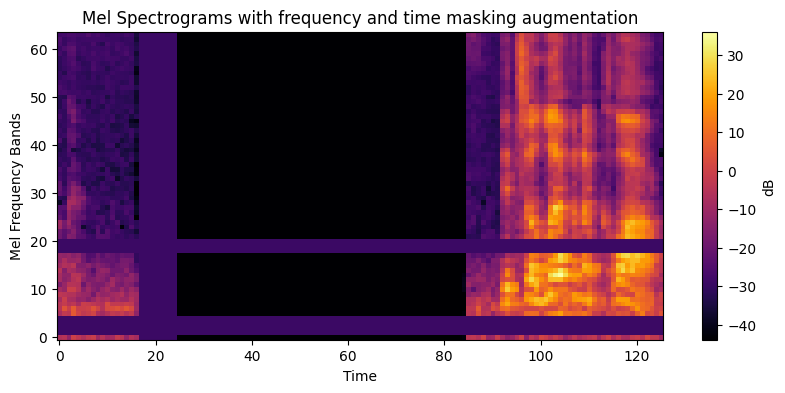

In [11]:
# Check size of mel spectrogram at the end: 
# e.g. (num_channels, Mel freq_bands, time_steps in spec) = (2, 64, 344)
sample_data, _ = next(iter(train_loader))
print("Shape of sample_data: ", "(batch_sz, num_channels, Mel freq_bands, time_steps)", sample_data.shape)
# torch.Size([16, 1, 64, 126])

mel_spectrogram = sample_data[0]

mel_shape = mel_spectrogram.shape
print("Shape of Mel Spectrogram:", "(num_channels, Mel freq_bands, time_steps in spec)", mel_shape, "\n")
# torch.Size([1, 64, 126])

# Spectrogram for 1st channel
mel_spectrogram = sample_data[0]

mel_spectrogram = mel_spectrogram.squeeze()

# Plot the Mel Spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram.numpy(), cmap='inferno', origin='lower')

n_freq_masks = 2
n_time_masks = 2

# Overlay frequency and time masking
for _ in range(n_freq_masks):
    freq_mask_range = torch.randint(1, mel_spectrogram.size(0)//2, (1,)).item()
    freq_mask_start = torch.randint(0, mel_spectrogram.size(0) - freq_mask_range, (1,)).item()
    mel_spectrogram[freq_mask_start:freq_mask_start+freq_mask_range, :] = mel_spectrogram.mean()

for _ in range(n_time_masks):
    time_mask_range = torch.randint(1, mel_spectrogram.size(1)//2, (1,)).item()
    time_mask_start = torch.randint(0, mel_spectrogram.size(1) - time_mask_range, (1,)).item()
    mel_spectrogram[:, time_mask_start:time_mask_start+time_mask_range] = mel_spectrogram.mean()

plt.title('Mel Spectrograms with frequency and time masking augmentation')
plt.xlabel('Time')
plt.ylabel('Mel Frequency Bands')
plt.colorbar(label='dB')
plt.show()

In [54]:
"""
Building Network architecture based on the paper:
Human–Computer Interaction with a Real-Time Speech
Emotion Recognition with Ensembling Techniques 1D
Convolution Neural Network and Attention
(https://doi.org/10.3390/s23031386)

We are taking the output of CNN as the input of LSTM.
CNN captures local patterns in audio features, and
LSTM learns temporal dependencies before making final prediction. This supports
robust sequence prediction.

TO DO/CHECK: Kaimingn initialization??
"""
class CNN_LSTM(nn.Module):
    def __init__(self, num_emotions):
        super(CNN_LSTM, self).__init__()
        # bn = batch normalization
        ####################
        # Convolution blocks: conv, batch norm, ReLU, max pooling
        # Conv block 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=(1,1), padding=(2,2))
        self.bn1 = nn.BatchNorm2d(8)

        # Conv block 2
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.bn2 = nn.BatchNorm2d(16)

        # Conv block 3
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(1,1), padding =(1,1))
        self.bn3 = nn.BatchNorm2d(32)

        # Conv block 4
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding =(1,1))
        self.bn4 = nn.BatchNorm2d(64)

        # Conv block 5
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding =(1,1))
        self.bn5 = nn.BatchNorm2d(128)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        ####################

        ####################
        # LSTM + attention block
        hidden_size=64
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=hidden_size, bidirectional=False, batch_first = True)

        self.attention_linear = nn.Linear(hidden_size, 1)
        self.softmax = nn.Softmax(dim=1)

        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, bidirectional=False, batch_first = True)
        ####################


        self.fc1 = nn.Linear(hidden_size, 64)
        self.bn6 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, num_emotions)


    def forward(self, x):
        # Conv block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Conv block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)

        # Conv block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)

        # Conv block 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.pool(x)

        # Conv block 5
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu(x)
        x = self.pool(x)

        # LSTM + attention block
        # output_tensor, hiddenstate = self.lstm()
#         print("shape of conv output: ", x.shape)
        
#         conv_emb = x
        conv_emb = torch.flatten(x, start_dim=2) # Do not flatten batch dimension and time
#         print("shape of conv output after flattening: ", conv_emb.shape)
        
        conv_emb = conv_emb.transpose(1, 2)  # Swap the dimensions
        conv_emb = conv_emb.reshape(conv_emb.size(0), conv_emb.size(1), -1)  # Reshape to (batch_size, time_steps, hidden_size)
#         print("Shape of conv output after reshape: ", conv_emb.shape)
        
        lstm1_out, (h,c) = self.lstm1(conv_emb) # (batch, time, hidden_size) # expects 128
        
        # Attention
        attention_weights = self.attention_linear(lstm1_out).squeeze(-1)
        attention_weights = F.softmax(attention_weights, dim=1).unsqueeze(-1)
        context_vector = torch.sum(attention_weights * lstm1_out, dim=1)

        lstm2_out, _ = self.lstm2(context_vector.unsqueeze(1))
        print("Shape of lstm2 output: ", lstm2_out.shape)
        # Fully connected layers
#         fc1_out = self.relu(self.fc1(lstm2_out.squeeze(1)))
        fc1_out = self.fc1(lstm2_out.squeeze(1))
#         print("Shape of fully connected layer 1: ", fc1_out.shape)
        fc1_out = self.bn6(fc1_out)
        x = self.fc2(fc1_out)

        return x

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_emotions = 10 # Mel freq_bands
net =  CNN_LSTM(num_emotions).to(device)
criterion = nn.CrossEntropyLoss()
optimizer =  optim.Adam(net.parameters(), lr=1e-4)

In [56]:
# summary(net, input_size=(16, 1, 64, 126))

In [61]:
# Training loop
root_dir = './runs'
os.makedirs(root_dir, exist_ok=True)

def train_on_features(net, optimizer, device, trainloader, criterion, num_epochs=1):
    if torch.cuda.is_available():
        net.cuda()
    net.train()

    loss_min = float('inf')
    for epoch in range(num_epochs):
        running_loss = 0
        correct_pred = 0
        total_pred = 0
        
        for i, data in enumerate(trainloader):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            
            # Normalize inputs
            mean_inputs, std_inputs = inputs.mean(), inputs.std()
            inputs = (inputs - mean_inputs) / std_inputs
            
            # Initializing by zero-ing out gradient
            optimizer.zero_grad()
#             print("shape of input into the model: ", inputs.shape)
            # Forward + Backward + Optimization
            forward_output = net(inputs) # pred
            loss = criterion(forward_output, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Prediction
            temp, pred = torch.max(forward_output, 1)
            label_indices = torch.argmax(labels, dim=1)
#             print("test: ", temp)
#             print("Shape of test: ", temp.shape)
#             print("pred: ", pred)
#             print("Shape of pred: ", pred.shape)
            
            # Counting correct predictions
            correct_pred += (pred == label_indices).sum().item()
            total_pred += pred.shape[0]
            
            if loss < loss_min:
                torch.save(net.state_dict(), os.path.join(root_dir, "best_ser_model.pth"))
        
        num_batches = len(trainloader)
        avg_loss = running_loss / num_batches
        accuracy = correct_pred / total_pred
        print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {accuracy:.2f}')


    print('Finished Training')
    return net


In [ ]:
Net = train_on_features(net, optimizer, device, train_loader, criterion)

shape of input into the model:  torch.Size([16, 1, 64, 126])
shape of conv output:  torch.Size([16, 128, 2, 3])
shape of conv output after flattening:  torch.Size([16, 128, 6])
Shape of conv output after reshape:  torch.Size([16, 6, 128])
Shape of lstm2 output:  torch.Size([16, 1, 64])
Shape of fully connected layer 1:  torch.Size([16, 64])
test:  tensor([0.6154, 0.7679, 0.3961, 0.7578, 0.2855, 0.6109, 0.1189, 0.7700, 0.3415,
        0.4490, 0.7992, 0.5356, 1.3754, 0.5923, 0.5847, 0.7530],
       device='cuda:0', grad_fn=<MaxBackward0>)
Shape of test:  torch.Size([16])
pred:  tensor([8, 9, 1, 9, 8, 5, 3, 9, 5, 7, 4, 3, 4, 5, 6, 9], device='cuda:0')
Shape of pred:  torch.Size([16])
shape of input into the model:  torch.Size([16, 1, 64, 126])
shape of conv output:  torch.Size([16, 128, 2, 3])
shape of conv output after flattening:  torch.Size([16, 128, 6])
Shape of conv output after reshape:  torch.Size([16, 6, 128])
Shape of lstm2 output:  torch.Size([16, 1, 64])
Shape of fully connecte

shape of input into the model:  torch.Size([16, 1, 64, 126])
shape of conv output:  torch.Size([16, 128, 2, 3])
shape of conv output after flattening:  torch.Size([16, 128, 6])
Shape of conv output after reshape:  torch.Size([16, 6, 128])
Shape of lstm2 output:  torch.Size([16, 1, 64])
Shape of fully connected layer 1:  torch.Size([16, 64])
test:  tensor([1.5584, 0.8276, 0.2995, 1.1970, 0.2804, 0.5861, 0.6955, 0.6664, 0.4958,
        0.3408, 1.0846, 0.2960, 0.3993, 1.0307, 0.8434, 0.5922],
       device='cuda:0', grad_fn=<MaxBackward0>)
Shape of test:  torch.Size([16])
pred:  tensor([8, 9, 4, 6, 7, 6, 0, 6, 9, 0, 6, 5, 5, 0, 6, 6], device='cuda:0')
Shape of pred:  torch.Size([16])
shape of input into the model:  torch.Size([16, 1, 64, 126])
shape of conv output:  torch.Size([16, 128, 2, 3])
shape of conv output after flattening:  torch.Size([16, 128, 6])
Shape of conv output after reshape:  torch.Size([16, 6, 128])
Shape of lstm2 output:  torch.Size([16, 1, 64])
Shape of fully connecte

shape of input into the model:  torch.Size([16, 1, 64, 126])
shape of conv output:  torch.Size([16, 128, 2, 3])
shape of conv output after flattening:  torch.Size([16, 128, 6])
Shape of conv output after reshape:  torch.Size([16, 6, 128])
Shape of lstm2 output:  torch.Size([16, 1, 64])
Shape of fully connected layer 1:  torch.Size([16, 64])
test:  tensor([1.0029, 0.6533, 0.4971, 0.1167, 0.8464, 0.7601, 0.8720, 0.6409, 0.0679,
        0.6339, 0.6054, 1.0745, 1.0781, 0.8663, 1.0829, 0.7774],
       device='cuda:0', grad_fn=<MaxBackward0>)
Shape of test:  torch.Size([16])
pred:  tensor([7, 6, 9, 5, 7, 6, 9, 5, 6, 5, 6, 8, 8, 7, 4, 4], device='cuda:0')
Shape of pred:  torch.Size([16])
shape of input into the model:  torch.Size([16, 1, 64, 126])
shape of conv output:  torch.Size([16, 128, 2, 3])
shape of conv output after flattening:  torch.Size([16, 128, 6])
Shape of conv output after reshape:  torch.Size([16, 6, 128])
Shape of lstm2 output:  torch.Size([16, 1, 64])
Shape of fully connecte

shape of input into the model:  torch.Size([16, 1, 64, 126])
shape of conv output:  torch.Size([16, 128, 2, 3])
shape of conv output after flattening:  torch.Size([16, 128, 6])
Shape of conv output after reshape:  torch.Size([16, 6, 128])
Shape of lstm2 output:  torch.Size([16, 1, 64])
Shape of fully connected layer 1:  torch.Size([16, 64])
test:  tensor([0.5781, 1.1712, 0.9604, 1.4557, 0.9143, 1.2864, 0.8562, 1.1126, 0.3983,
        0.5008, 0.8854, 0.7286, 0.4648, 0.6066, 0.6997, 0.5076],
       device='cuda:0', grad_fn=<MaxBackward0>)
Shape of test:  torch.Size([16])
pred:  tensor([5, 8, 6, 7, 4, 6, 6, 8, 9, 6, 9, 9, 9, 7, 0, 0], device='cuda:0')
Shape of pred:  torch.Size([16])
shape of input into the model:  torch.Size([16, 1, 64, 126])
shape of conv output:  torch.Size([16, 128, 2, 3])
shape of conv output after flattening:  torch.Size([16, 128, 6])
Shape of conv output after reshape:  torch.Size([16, 6, 128])
Shape of lstm2 output:  torch.Size([16, 1, 64])
Shape of fully connecte

In [40]:
# TESTING
# Assuming your input data has the shape (batch_sz, num_channels, Mel freq_bands, time_steps)
# input_data = torch.randn(16, 1, 64, 126)  # Example input data

# # Reshape the input data to flatten along the time axis (time_steps)
# # The new shape will be (batch_sz, Mel freq_bands, time_steps)
# reshaped_input = input_data.permute(0, 2, 3, 1).reshape(input_data.size(0), input_data.size(2), -1)

# # Check the shape of the reshaped input
# print("Shape of reshaped input:", reshaped_input.shape)

Shape of reshaped input: torch.Size([16, 64, 126])


In [45]:
# '''
# Feature Extraction
# 1) Wav2vec2 model
# '''
# bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H # can choose another wav2vec2 model
# print("Sample rate: ", bundle.sample_rate)
# print("Labels: ", bundle.get_labels())
# model = bundle.get_model().to(device)

# # Example audio
# SPEECH_FILE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
# IPython.display.Audio(SPEECH_FILE)
# waveform, sample_rate = torchaudio.load(SPEECH_FILE)
# waveform = waveform.to(device)
# # Resample example audio if its sample rate doesn't match the pipeline's sample rate
# if sample_rate != bundle.sample_rate:
#     print("Audio vs Bundle sample rate: ", sample_rate, bundle.sample_rate)
#     waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)
    
# # Extract features
# with torch.inference_mode():
#     features, _ = model.extract_features(waveform)
    

In [8]:
# '''
# Feature Extraction
# 2) Hand-crafted features: ZCR, RMSE, MFCC
# '''
# X, sample_rate = librosa.load('./datasets/berlin-database-of-emotional-speech-emodb/wav/03a01Fa.wav')
# mfccs = np.mean(librosa.feature.mfcc(y=X, n_mfcc=25,), axis = 0) # calculating mean?
# rms = librosa.feature.rms(y=X) # root mean square value for each frame of audio sample
# zcr = librosa.feature.zero_crossing_rate(y=X) # zero crossing rate of audio time series

In [44]:
# # Let's visualize what we are doing!
# # some of this code taken from https://github.com/MiteshPuthran/Speech-Emotion-Analyzer/blob/master/final_results_gender_test.ipynb
# import librosa.display
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10,5))
# librosa.display.waveshow(X, sr=sample_rate)

In [10]:
# putting features into dataframes
# needs "/" at end of filepath
# data_filepath = "./datasets/berlin-database-of-emotional-speech-emodb/wav/"

# database_name = "berlin-database-of-emotional-speech-emodb"
# filenames_list = os.listdir(data_filepath) # filenames without full filepath
# full_filenames_list = [data_filepath + filename for filename in filenames_list] # adding full filepath



In [43]:
# # extract features of all audio files into a dataframe
# import pandas as pd

# features_df = pd.DataFrame(columns=['filename', 'mfccs', 'rms', 'zcr', 'emotion'])

# # works for a single folder of audio files at once, all from the same dataset
# for i, filename in enumerate(full_filenames_list):
#     X, sample_rate = librosa.load(filename) # load waveform
#     mfccs = np.mean(librosa.feature.mfcc(y=X, n_mfcc=25,), axis = 0) # calculate feature values
#     rms = librosa.feature.rms(y=X)
#     zcr = librosa.feature.zero_crossing_rate(y=X)
#     features_df.at[i, 'mfccs'] = mfccs # save X features to dataframe
#     features_df.at[i, 'rms'] = np.array(rms)
#     features_df.at[i, 'zcr'] = np.array(zcr)
    
#     row_index = df.loc[df['filename'] == filename].index[0] # finding the correct emotion for the filename
#     features_df.at[i, 'emotion'] = df.at[row_index,'emotion'] # selects correct emotion from Noah's df
    
#     split_name = filename.split('/') # get the correct filename
#     features_df.at[i, 'filename'] = split_name[-1]
    
#     #features_df.at[i,'emotion'] = df.loc['im','emotion']

# #features_df = pd.concat([features_df, labels_df], axis=1)
# print(features_df)

In [12]:
# Now let's shuffle these boiz
from sklearn.model_selection import train_test_split
train, test = train_test_split(features_df, test_size=0.2, random_state=42, shuffle=True)


train shape: (428, 5)



In [36]:
# # Training loop
# root_dir = './runs'
# os.makedirs(root_dir, exist_ok=True)

# def train_on_features(net, optimizer, device, trainloader, critrerion, epochs=1):
#     if torch.cuda.is_available():
#         net.cuda()
#     net.train()

#     loss_min = float('inf')
#     for epoch in range(epochs):
#         for i, data in enumerate(trainloader):
#             inputs, labels = data
#             inputs, labels = inputs.to(device), labels.to(device)

#             optimizer.zero_grad()

#             pred = net(inputs)
#             loss = criterion(pred, labels)
#             loss.backward()
#             optimizer.step()
            
#             if loss < loss_min:
#                 torch.save(net.state_dict(), os.path.join(root_dir, "best_ser_model.pth"))


#     print('Finished Training')
#     return net

# net = train_on_features(net, optimizer, device, trainloader, criterion)

AttributeError: 'tuple' object has no attribute 'to'

In [37]:
#net = train_on_features(net, optimizer, device, trainloader, criterion)
# trainloader = DataLoader(trainset, batch_size=1, shuffle=True, num_workers=1)
# for i, data in enumerate(trainloader):
#     print(data)
# print(trainset[0])

(tensor([ 9.1553e-05, -3.0518e-04, -7.9346e-04,  ..., -1.2207e-03,
        -1.4343e-03, -1.5259e-03]), 'anxiety')
